In [1]:

import argparse
import os
import torch
import numpy as np
import random
import wandb
import models
import yaml
from trainer import Trainer
import pprint
from torchvision import transforms
import datasets


np.random.seed(0)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True


def get_dataset(dataset, noise_rate, noise_type):
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if dataset == "noisy_cifar10":
        train = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=noise_rate, noise_type=noise_type)
        test = datasets.CIFAR10("./data", download=True, train=False, transform=transform_test)
    elif dataset == "noisy_cifar100":
        train = datasets.NoisyCIFAR100("./data", download=True, transform=transform_train, noise_rate=noise_rate, noise_type=noise_type)
        test = datasets.CIFAR100("./data", download=True, train=False, transform=transform_test)
    else:
        raise NotImplementedError
    return train, test



In [2]:
# # Load YAML config
# with open("./configs/train_base.yml", 'r') as file:
#     config = yaml.safe_load(file)

# read YAML file from string
config = yaml.safe_load("""
data:
  dataset: noisy_cifar10
  noise_rate: 0.4
  noise_type: symmetric

model:
  architecture: resnet18
  num_classes: 10

wandb:
  mode: disabled # "disabled" or "online"
  entity: siit-iitp
  project: noisy-label

trainer:
  optimizer: sgd
  init_lr: 1.0e-1
  momentum: 0.9
  weight_decay: 1.0e-4
  lr_scheduler: multistep
  max_epoch: 200
  loss_fn: cross_entropy
  num_classes: 10
  num_workers: 2
  batch_size: 512
  save_model: true
""")

pprint.pprint(config)

model = models.get_model(**config["model"]).cuda()


# NoisyCIFAR10(symm,0.4)-CE: mquy2drg
# NoisyCIFAR10(symm,0.4)-MAE: ccnf390c

def load_checkpoint(name="model_199.pth"):
  checkpoint = wandb.restore(name, run_path="siit-iitp/noisy-label/mquy2drg", replace=True)
  model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))

load_checkpoint("model_199.pth")

trainer = Trainer(
                model=model,
                config=config['trainer'],
                )

# result = trainer.filter_noisy(train_dataset)
print(trainer.criterion)

{'data': {'dataset': 'noisy_cifar10',
          'noise_rate': 0.4,
          'noise_type': 'symmetric'},
 'model': {'architecture': 'resnet18', 'num_classes': 10},
 'trainer': {'batch_size': 512,
             'init_lr': 0.1,
             'loss_fn': 'cross_entropy',
             'lr_scheduler': 'multistep',
             'max_epoch': 200,
             'momentum': 0.9,
             'num_classes': 10,
             'num_workers': 2,
             'optimizer': 'sgd',
             'save_model': True,
             'weight_decay': 0.0001},
 'wandb': {'entity': 'siit-iitp', 'mode': 'disabled', 'project': 'noisy-label'}}
CrossEntropyLoss()


In [3]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=config["data"]["noise_rate"], noise_type=config['data']['noise_type'])


# def wrap_forward(model)
#     @torch.no_grad()
#     def forward_fn(x):
#         for batch in range(0,)

#     return forward_fn



with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = []

    for ep in range(9, 200, 10):
        load_checkpoint(f"model_{ep}.pth")

        result = {
            'std': [],
            'mean': [],
            'is_noisy': [],
        }
        for batch in dataloader:
            data, target = batch["image"].cuda(), batch["target"].cuda()
            target_gt = batch["target_gt"].cuda()
            losses = []
            for _ in range(10):
                # data_ = torch.normal(transform_normalize(data), 0.1)
                data_ = transform_tta(data)
                output = trainer.model(data_)
                loss = trainer.criterion(output, target)
                losses.append(loss)
            std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
            is_noisy = (target != target_gt)
            result['std'].append(std)
            result['mean'].append(mean)
            result['is_noisy'].append(is_noisy)

        result['std'] = torch.cat(result['std'], dim=0).cpu()
        result['mean'] = torch.cat(result['mean'], dim=0).cpu()
        result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()
        results.append(result)

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'mean': tensor([2.3998, 0.1634, 1.0441,  ..., 0.4084, 4.4017, 4.0002]),
 'std': tensor([3.8567, 0.5163, 2.2610,  ..., 1.2317, 4.8858, 5.0573])}


In [4]:
torch.save(results, "./test-time.pth")

In [6]:
results = torch.load("./test-time.pth")
results

[{'std': tensor([0.3953, 0.9655, 0.5792,  ..., 0.2563, 0.2605, 0.3639]),
  'mean': tensor([2.4883, 0.8498, 2.0863,  ..., 1.6704, 2.0929, 2.5285]),
  'is_noisy': tensor([ True, False, False,  ..., False,  True,  True])},
 {'std': tensor([0.4122, 0.3469, 0.5443,  ..., 0.4396, 0.5589, 0.2217]),
  'mean': tensor([1.4883, 0.5582, 2.2245,  ..., 2.1083, 3.1015, 3.4138]),
  'is_noisy': tensor([ True, False, False,  ..., False,  True,  True])},
 {'std': tensor([0.7069, 0.3800, 1.0008,  ..., 0.3525, 0.8368, 0.7222]),
  'mean': tensor([1.3300, 0.3984, 0.7235,  ..., 0.8989, 2.7706, 2.2364]),
  'is_noisy': tensor([ True, False, False,  ..., False,  True,  True])},
 {'std': tensor([0.4456, 0.1791, 0.5400,  ..., 0.4649, 0.2851, 0.4198]),
  'mean': tensor([2.0822, 0.4843, 0.5398,  ..., 0.9208, 2.6893, 2.5303]),
  'is_noisy': tensor([ True, False, False,  ..., False,  True,  True])},
 {'std': tensor([0.9408, 1.2579, 1.8251,  ..., 0.5292, 0.6392, 0.7903]),
  'mean': tensor([2.6652, 1.1722, 1.9630,  ...,

In [9]:
import pandas as pd
from sklearn.metrics import roc_auc_score

temp = []
for result in results:
    temp.append({
        'loss mean': roc_auc_score(result['is_noisy'], result['mean']),
        'mean + 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] + 0.5*result['std']),
        'mean - 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] - 0.5*result['std']),
        'std': roc_auc_score(result['is_noisy'], result['std']),
    })

temp = pd.DataFrame(temp)
temp

,loss mean,mean + 0.5*std,mean - 0.5*std,std
0,0.932600,0.927527,0.932458,0.275136
1,0.959489,0.953886,0.961388,0.271245
2,0.970002,0.964369,0.971836,0.293698
3,0.957120,0.946790,0.961824,0.325727
4,0.943819,0.927892,0.950798,0.382064
5,0.921580,0.898260,0.933404,0.477624
6,0.806043,0.778437,0.814315,0.649958
7,0.787467,0.772039,0.780675,0.695333
8,0.751323,0.741448,0.734461,0.693041
9,0.763133,0.751684,0.748512,0.702054


In [10]:
temp['epoch'] = list(range(9,200,10))
temp = temp.set_index('epoch')
temp

,loss mean,mean + 0.5*std,mean - 0.5*std,std
epoch,,,,
9,0.932600,0.927527,0.932458,0.275136
19,0.959489,0.953886,0.961388,0.271245
29,0.970002,0.964369,0.971836,0.293698
39,0.957120,0.946790,0.961824,0.325727
49,0.943819,0.927892,0.950798,0.382064
59,0.921580,0.898260,0.933404,0.477624
69,0.806043,0.778437,0.814315,0.649958
79,0.787467,0.772039,0.780675,0.695333
89,0.751323,0.741448,0.734461,0.693041


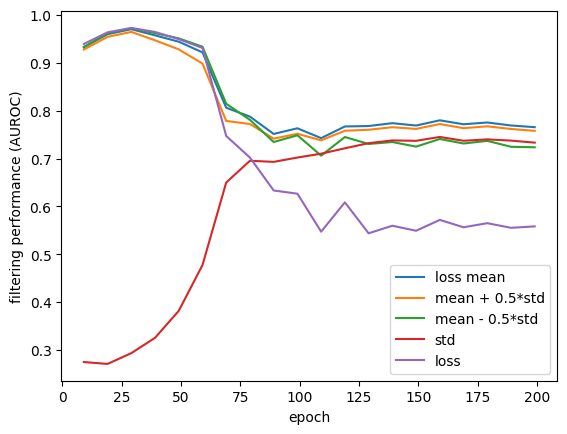

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# create a sample dataframe with four columns
df = temp

# plot the dataframe using Matplotlib
fig, ax = plt.subplots()
df.plot(ax=ax)

# set the plot title and axis labels
ax.set_xlabel('epoch')
ax.set_ylabel('filtering performance (AUROC)')

# show the plot
plt.show()


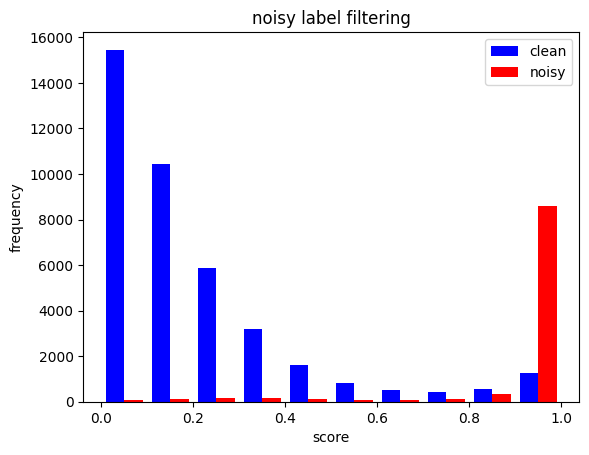

0.9691574631369061


In [79]:
import matplotlib.pyplot as plt

score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
# score = result['std']

blue_data = score[~result['is_noisy']]
red_data = score[result['is_noisy']]

plt.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])
# plt.hist(blue_data, bins=np.arange(0, 8, 0.5), color='blue', alpha=0.5, label="clean")
# plt.hist(red_data, bins=np.arange(0, 8, 0.5), color='red', alpha=0.5, label="noisy")

# add title and axis labels
plt.title("noisy label filtering")
plt.xlabel("score")
plt.ylabel("frequency")

# add legend
plt.legend()

# display the histogram
plt.show()


from sklearn.metrics import roc_auc_score
print(roc_auc_score(result['is_noisy'], score))


In [4]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=config["data"]["noise_rate"], noise_type=config['data']['noise_type'])


# def wrap_forward(model)
#     @torch.no_grad()
#     def forward_fn(x):
#         for batch in range(0,)

#     return forward_fn



with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = []

    for ep in range(9, 200, 10):
        load_checkpoint(f"model_{ep}.pth")

        result = {
            'loss': [],
            'is_noisy': [],
        }
        for batch in dataloader:
            data, target = batch["image"].cuda(), batch["target"].cuda()
            target_gt = batch["target_gt"].cuda()
            data = transform_normalize(data)
            output = trainer.model(data)
            loss = trainer.criterion(output, target)
            result['loss'].append(loss)
            is_noisy = (target != target_gt)
            result['is_noisy'].append(is_noisy)

        result['loss'] = torch.cat(result['loss'], dim=0).cpu()
        result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()
        results.append(result)

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'loss': tensor([1.0228e-04, 5.1260e-06, 8.7734e-05,  ..., 1.1325e-05, 1.0188e-01,
        3.9422e-03])}


In [5]:
import pandas as pd
from sklearn.metrics import roc_auc_score

temp = []
for result in results:
    temp.append({
        'loss': roc_auc_score(result['is_noisy'], result['loss'])
    })

temp = pd.DataFrame(temp)

temp['epoch'] = list(range(9,200,10))
temp = temp.set_index('epoch')
temp

,loss
epoch,
9,0.939078
19,0.963389
29,0.972621
39,0.964173
49,0.949150
59,0.930824
69,0.747012
79,0.701947
89,0.633265


In [8]:
temp2 = temp.copy()

In [12]:
temp["loss"] = temp2['loss']

In [13]:
temp

,loss mean,mean + 0.5*std,mean - 0.5*std,std,loss
epoch,,,,,
9,0.932600,0.927527,0.932458,0.275136,0.939078
19,0.959489,0.953886,0.961388,0.271245,0.963389
29,0.970002,0.964369,0.971836,0.293698,0.972621
39,0.957120,0.946790,0.961824,0.325727,0.964173
49,0.943819,0.927892,0.950798,0.382064,0.949150
59,0.921580,0.898260,0.933404,0.477624,0.930824
69,0.806043,0.778437,0.814315,0.649958,0.747012
79,0.787467,0.772039,0.780675,0.695333,0.701947
89,0.751323,0.741448,0.734461,0.693041,0.633265
